#### Construct a network unsupervised feature learning method?

Import library

In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize
from root_numpy import tree2array,array2tree,array2root
import ROOT

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Conv2DTranspose, UpSampling2D, UpSampling1D

Welcome to JupyROOT 6.10/02


Using TensorFlow backend.


CPU times: user 3.84 s, sys: 546 ms, total: 4.38 s
Wall time: 4.63 s


### import data: create a generator to fit

In [2]:
%time
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def reader_pmt(path):
    extra = np.arange(4096, 4480)
    x_file = ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x_pmtall = tree2array(x_tree, branches="PMTALL")
    x = np.delete(x_pmtall, extra, axis=1)
    return x

def reader_para(path,para1,para2,para3,para4,para5,para6,para7,para8,para9):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = np.expand_dims(tree2array(x_tree, branches=para1 ),axis=1)
    x2 = tree2array(x_tree, branches=para2 )
    x3 = tree2array(x_tree, branches=para3 )
    x4 = tree2array(x_tree, branches=para4 )
    x5 = tree2array(x_tree, branches=para5 )
    x6 = tree2array(x_tree, branches=para6 )
    x7 = tree2array(x_tree, branches=para7 )
    x8 = tree2array(x_tree, branches=para8 )
    x9 = tree2array(x_tree, branches=para9 )
#     x10 = tree2array(x_tree, branches=para10 )
    
    x = np.stack((x1[:,0],x2[:,1],x3[:,0],x3[:,1],x3[:,2],x3[:,3],x4[:,1],x4[:,7],x4[:,13],x4[:,22],x5[:,33],x5[:,36],x6[:,0],x7[:,1],x8,x9),axis=-1)
    return x

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def comb5(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)    
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

import random
from sklearn.preprocessing import normalize

classes = 7
group = 5

def generator(x):
    while 1:
        alpha = reader_pmt("Alpha.root")
#         bad1 = reader_pmt("BAD_DATA_QUALITY_1.root")
#         bad2 = reader_pmt("BAD_DATA_QUALITY_2.root")
        piled = reader_pmt("Piled_2.root")
        ls = reader_pmt("LS.root")
        lsbeta = reader_pmt("lsbeta.root")
        ref = reader_pmt("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
        z1_n = normalize(z1, norm="l1")
#         print(len(z1))

        Ratio4us_piled = reader_para("Piled_2.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_alpha = reader_para("Alpha.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_ls = reader_para("LS.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_lsbeta = reader_para("lsbeta.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_ref = reader_para("RefPulse009.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        
        z3, z4 = comb5(Ratio4us_piled,Ratio4us_ref,Ratio4us_alpha,Ratio4us_ls,Ratio4us_lsbeta,x)
        
#         s2 = np.random.permutation(np.arange(len(z4)))
        
        z3 = z3[s] 
        z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
#             if waveform == "waveform":
                p = np.expand_dims(z1[i],axis=0)
                p = gasf.transform(p)
                q = keras.utils.to_categorical(np.random.randint(classes),classes)
                r = np.expand_dims(z1_n[i],axis=0)
                s = np.expand_dims(z3[i],axis=0)
                p2 = np.expand_dims(p,axis=3)
                yield p,p2
                
#             if waveform == "waveform_1d":
#                 p = np.expand_dims(z1_n[i],axis=0)
#                 q = keras.utils.to_categorical(z2[i],classes)
#                 yield(p,q)
        
#         for i in range(len(z3)):
#             if waveform == "parameters":
#                 p = np.expand_dims(z3[i],axis=0)
#                 q = keras.utils.to_categorical(z4[i],group)
#                 yield(p,q)
        
# # test = generator(0,"waveform")
# # print(next(test)[0].shape)
# test = generator(1)
# print(next(test)[0][0].shape)
# print(next(test)[0][1].shape)
# print(next(test)[0][2].shape)
# test = generator(0)
# # print(next(test).shape)
# print(next(test)[1].shape)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


### define the autoencoders

In [3]:
feed_2d = Input(shape=(128,128))
model_en = Reshape((128,128,1),input_shape=(128,128))(feed_2d)
model_en = Conv2D(2, kernel_size=1)(model_en)
model_en = MaxPooling2D(pool_size=2)(model_en)
model_en = Activation("relu")(model_en)
model_en = Conv2D(4, kernel_size=1)(model_en)
model_en = MaxPooling2D(pool_size=2)(model_en)
model_en = Activation("relu")(model_en)
# model_en = Conv2D(8, kernel_size=1)(model_en)
# model_en = MaxPooling2D(pool_size=2)(model_en)
# model_en = Activation("relu")(model_en)
model_en = Flatten()(model_en)
# model_en = Dense(256,activation="relu")(model_en)
# model_en = Dropout(0.2)(model_en)
model_en = Dense(128,activation="relu")(model_en)
model_en = Dropout(0.2)(model_en)
model_en = Dense(64,activation="relu")(model_en)
model_en = Dropout(0.2)(model_en)

model_de = Dense(128,activation="relu")(model_en)
model_de = Dropout(0.2)(model_de)
# model_de = Dense(256,activation="relu")(model_de)
# model_de = Dropout(0.2)(model_de)
# model_de = Reshape((256,1),input_shape=(256,))(model_de)
# model_de = UpSampling1D(16)(model_de)
# model_de = Dense(4,activation="relu")(model_de)
# model_de = UpSampling1D(4)(model_de)
# model_de = Dense(4,activation="relu")(model_de)

model_de = Dense(4096,activation="relu")(model_de)
model_de = Dropout(0.2)(model_de)
model_de = Reshape((32,32,4),input_shape=(4096,))(model_de)
model_de = UpSampling2D(size=(2, 2))(model_de)
model_de = Conv2DTranspose(4,1)(model_de)
model_de = UpSampling2D(size=(2, 2))(model_de)
model_de = Conv2DTranspose(2,1)(model_de)
# model_de = UpSampling2D(size=(2, 2))(model_de)
model_de = Conv2DTranspose(1,1)(model_de)

autoencoder = Model(feed_2d,model_de)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# encoder = autoencoders_1d_en()

# def autoencoders_1d_de():
#     return


# mult = multiple_inputs()
# mult.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 2)       4         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 2)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 4)         12        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 4)         0         
__________

## Fit the model

Epoch 1/10
21430/21430 [==============================] - 457s - loss: 0.4854 - acc: 5.1038e-05 - val_loss: 0.5339 - val_acc: 5.8643e-05
Epoch 2/10
21430/21430 [==============================] - 439s - loss: 0.5405 - acc: 7.1035e-05 - val_loss: 0.5242 - val_acc: 5.8623e-05
Epoch 3/10
21430/21430 [==============================] - 442s - loss: 0.5331 - acc: 7.1132e-05 - val_loss: 0.5169 - val_acc: 5.8623e-05
Epoch 4/10
21430/21430 [==============================] - 433s - loss: 0.5323 - acc: 7.1189e-05 - val_loss: 0.5161 - val_acc: 5.8643e-05
Epoch 5/10
21430/21430 [==============================] - 431s - loss: 0.5316 - acc: 7.1186e-05 - val_loss: 0.5169 - val_acc: 5.8603e-05
Epoch 6/10
21430/21430 [==============================] - 438s - loss: 0.5320 - acc: 7.1220e-05 - val_loss: 0.5177 - val_acc: 5.8603e-05
Epoch 7/10
21430/21430 [==============================] - 433s - loss: 0.5333 - acc: 7.0927e-05 - val_loss: 0.5178 - val_acc: 5.8623e-05
Epoch 8/10
21430/21430 [=================

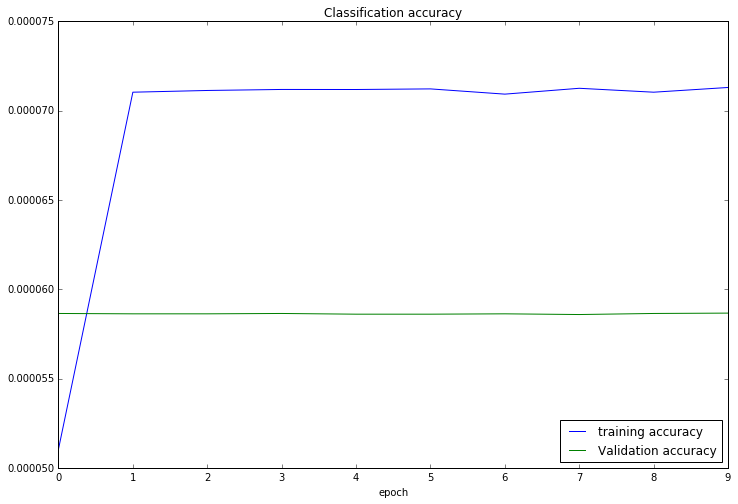

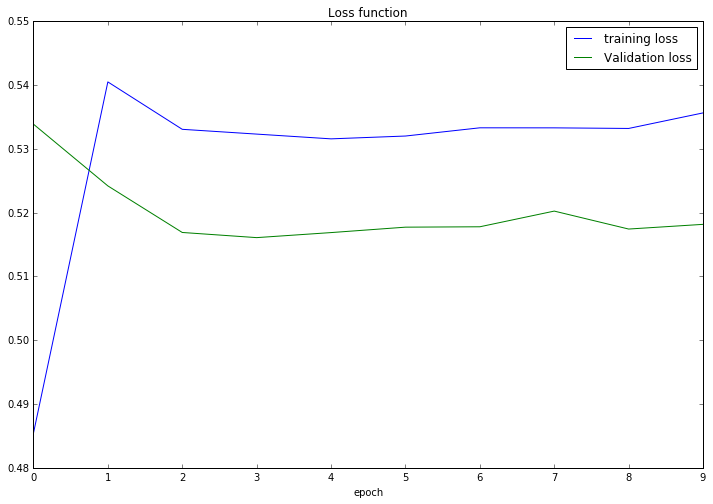

Classification accuracy = 5.86631171926e-05
Test loss: 0.517965233458
Test accuracy: 5.87229164966e-05


2018-03-01 16:19:36.400749: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX


In [4]:
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 21430
steps_vt = 3062

# from keras.models import load_model

# mult = load_model("combined_3_network.h5")

history = autoencoder.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=10, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

# mult.save("3network_random_label.h5")

score = autoencoder.evaluate_generator(test_gen,steps=1531)
print('Test loss:', score[0])
print('Test accuracy:', score[1])




(1, 128, 128)
(128, 128)
(128, 128)


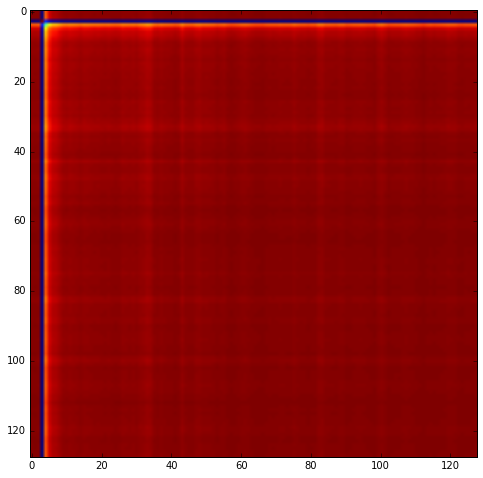

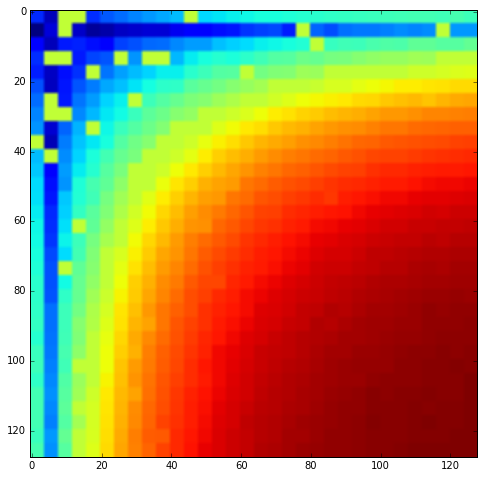

In [38]:
test_img = next(test_gen)[0]

print(test_img.shape)

reconstructed = autoencoder.predict(test_img)
reconstructed = np.squeeze(reconstructed)
# print(np.delete(np.squeeze(reconstructed[0].shape),2))



print(reconstructed.shape)

test_img_plt = np.squeeze(test_img)
print(test_img_plt.shape)

plt.figure()
plt.imshow(test_img_plt)
plt.show()


plt.figure()
plt.imshow(reconstructed)
plt.show()


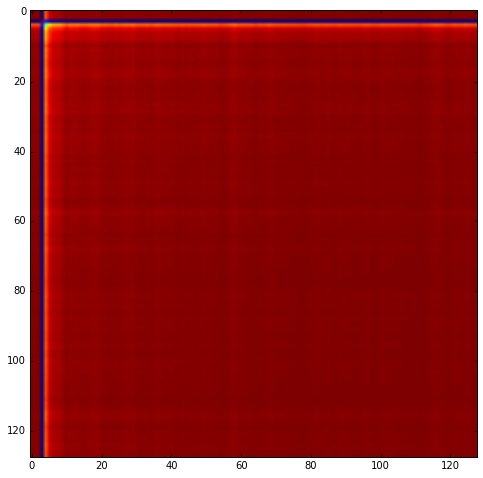

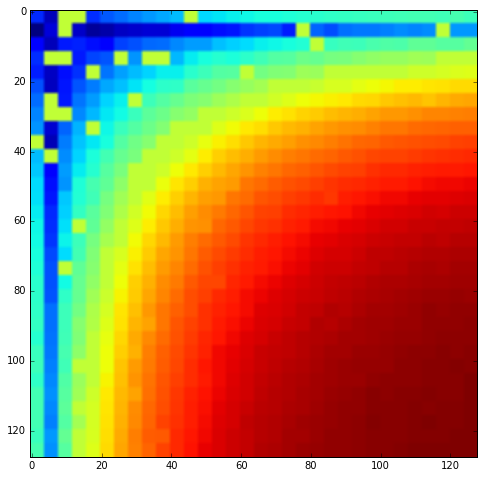

In [41]:
test_img = next(test_gen)[0]

reconstructed = autoencoder.predict(test_img)
reconstructed = np.squeeze(reconstructed)
# print(np.delete(np.squeeze(reconstructed[0].shape),2))

test_img_plt = np.squeeze(test_img)

plt.figure()
plt.imshow(test_img_plt)
plt.show()


plt.figure()
plt.imshow(reconstructed)
plt.show()